# **Project: Cat or Dog Image Classification**


Project description:

We are given a set of dog and cat images. Using these images, you need to train a deep learning image classification model, with descent accuracy of at least 90%. The task is to build a model to predict the category of an animal: dog or cat if an image is passed to the model.


Dataset Description:

There are 2 folders shared with the problem statement, which are of Train and Test folders. Containing various images of Cat and Dog.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Import Library**

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Define Constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Training Data

In [4]:
filenames = os.listdir("/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,dog.108.jpg,1
1,dog.100.jpg,1
2,dog.140.jpg,1
3,dog.107.jpg,1
4,dog.0.jpg,1


In [6]:
df.tail()

,filename,category
397,cat.97.jpg,0
398,cat.87.jpg,0
399,cat.96.jpg,0
400,cat.93.jpg,0
401,cat.71.jpg,0


### See Total In counts

<Axes: xlabel='category'>

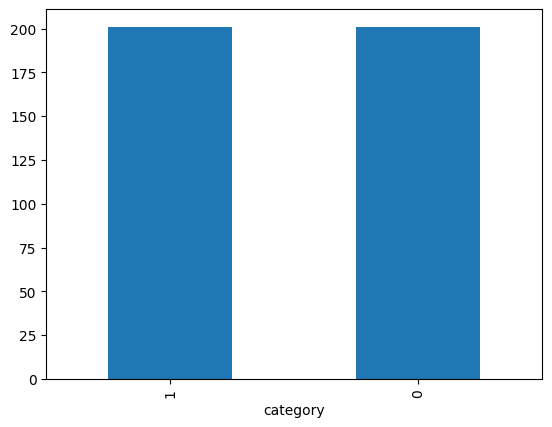

In [7]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

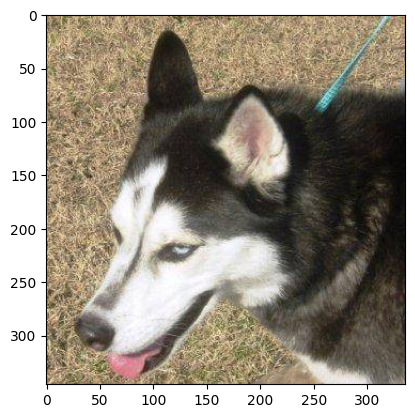

In [8]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/train/"+sample)
plt.imshow(image)

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [10]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [11]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

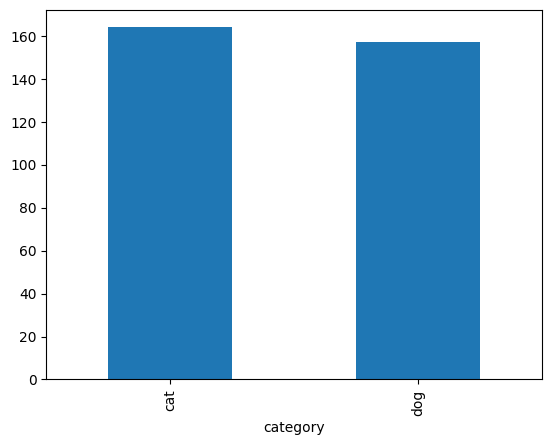

In [13]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

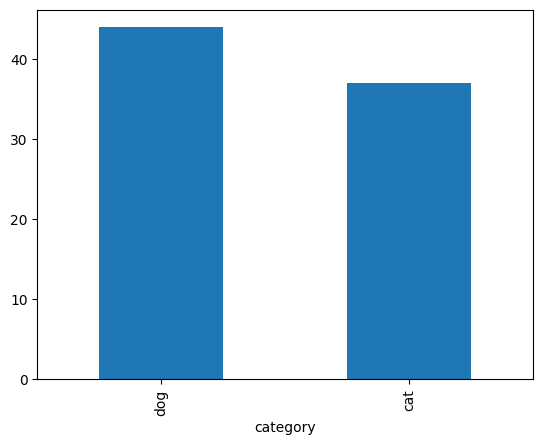

In [14]:
validate_df['category'].value_counts().plot.bar()

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 321 validated image filenames belonging to 2 classes.


### Validation Generator

In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 81 validated image filenames belonging to 2 classes.


# See how our generator work

In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


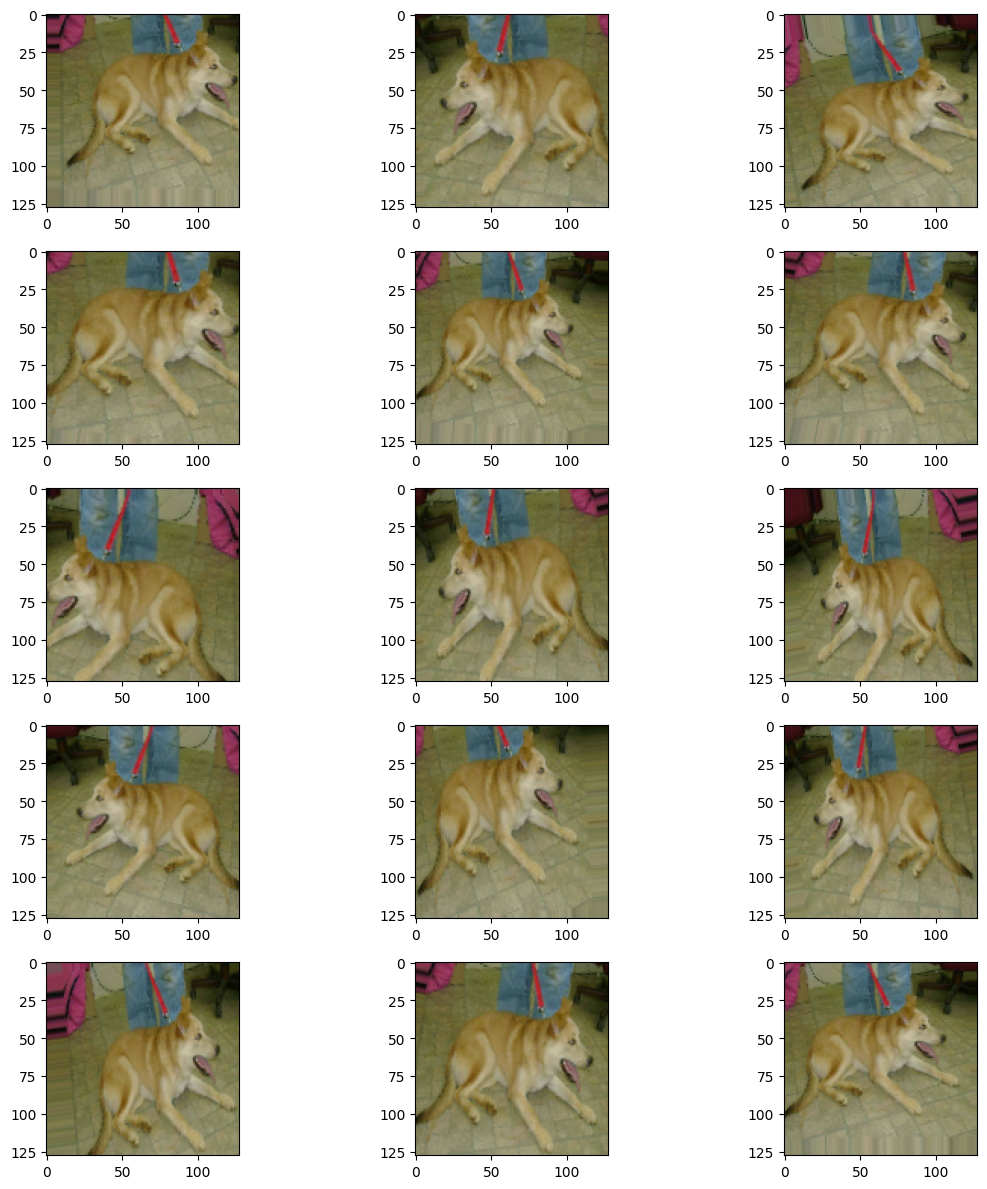

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice

# Fit Model

In [20]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

<ipython-input-20-a3a9d1edf606>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
21/21 [==============================] - 24s 983ms/step - loss: 1.9194 - accuracy: 0.5261 - val_loss: 2.0822 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 21s 959ms/step - loss: 1.1360 - accuracy: 0.6013 - val_loss: 4.9957 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9561 - accuracy: 0.6438
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 24s 1s/step - loss: 0.9561 - accuracy: 0.6438 - val_loss: 8.9645 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 22s 1s/step - loss: 0.8999 - accuracy: 0.6176 - val_loss: 7.3061 - val_accuracy: 0.4400 - lr: 5.0000e-04
Epoch 5/50
21/21 [==============================] - 20s 961ms/step - loss: 0.9324 - accuracy: 0.6405 - val_loss: 0.8825 - val_accuracy: 0.6000 - lr: 5.0000e-04
Epoch 6/50
21/21 [==============================] - 23s 1s/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualize Training

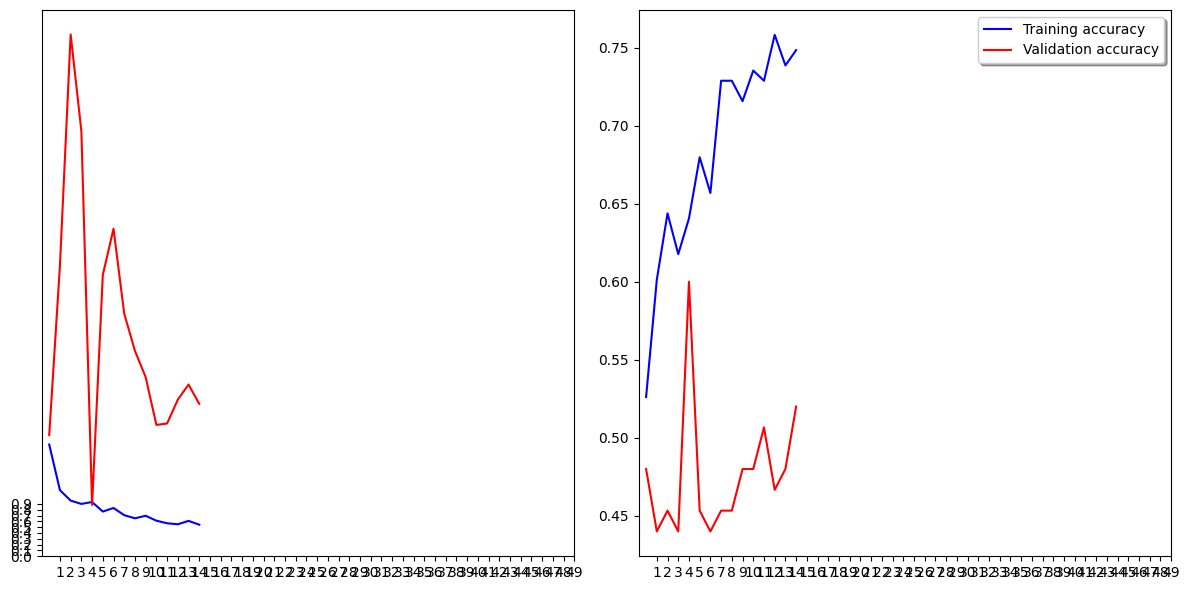

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

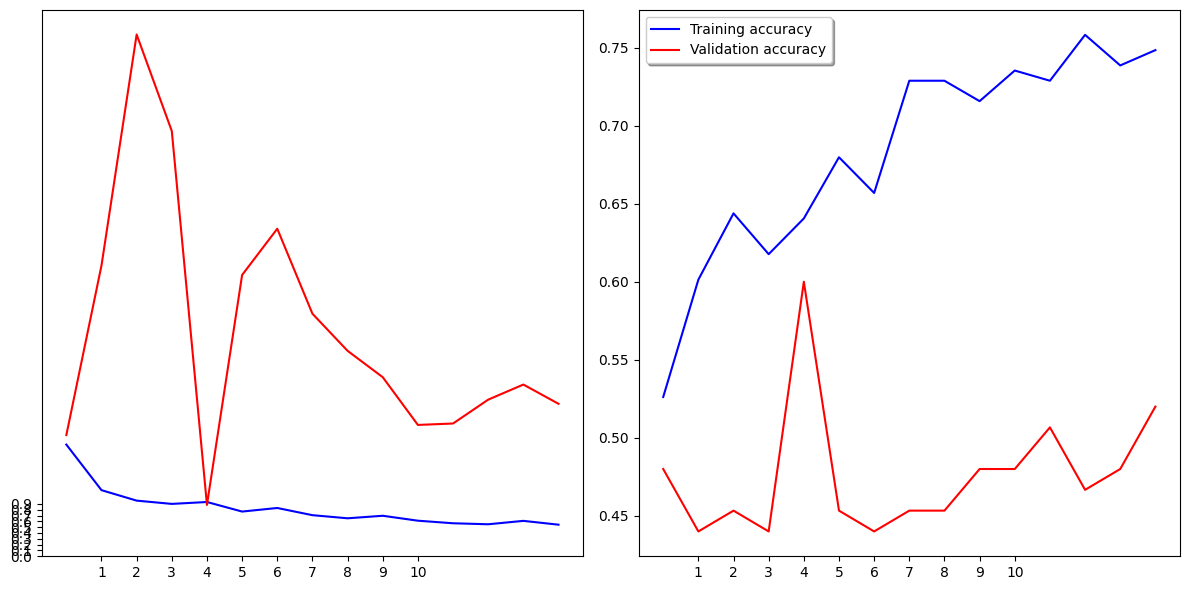

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# **Make the predictions for Multiple Images**


In [26]:

from google.colab.patches import cv2_imshow


1/1 [==============================] - 0s 282ms/step
dog


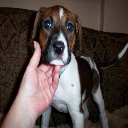

1/1 [==============================] - 0s 57ms/step
dog


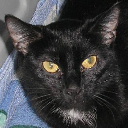

1/1 [==============================] - 0s 35ms/step
dog


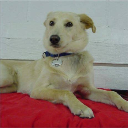

1/1 [==============================] - 0s 35ms/step
dog


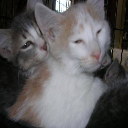

1/1 [==============================] - 0s 76ms/step
dog


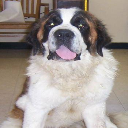

1/1 [==============================] - 0s 36ms/step
dog


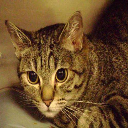

1/1 [==============================] - 0s 36ms/step
dog


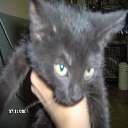

1/1 [==============================] - 0s 38ms/step
dog


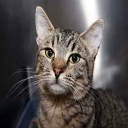

In [27]:
for i in range(8):
    all_test_images = os.listdir('/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/test')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'/content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/test/{random_image}')
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    org = img.copy()
    img = img.reshape(1, 128, 128, 3)
    pred = model.predict(img)
    print(['cat', 'dog'][int(pred[0][0])])
    cv2_imshow(org)  # Use cv2_imshow instead of cv2.imshow
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Make the predictions for a single test image

Path of the image to be predicted: /content/drive/MyDrive/Cat_Dog_Classifiyer/Cat_Dog_Classifiyer/test/10.jpg


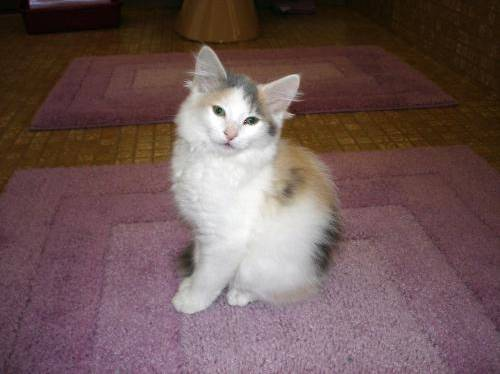

1/1 [==============================] - 0s 51ms/step
[[0.8874657  0.11253426]]
0
The image represents a Cat


In [30]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv2.resize(input_image, (128, 128))  # Resize the image to match the expected input shape

input_image_scaled = input_image_resized/255

image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)

print(input_pred_label)

if input_pred_label == 0:
  print('The image represents a Cat')

else:
  print('The image represents a Dog')